# Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from numpy.core.fromnumeric import size
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})
from sklearn.model_selection import cross_val_score

# Loading the dataframe

In [ ]:
# @title Data retrieval
import os, requests

fname = "allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
url = "https://ndownloader.figshare.com/files/28470255"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
filename = "allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
data = pd.read_parquet(filename)

In [ ]:
print(len(data['image_name'].unique()))


17


In [ ]:
data.head()

,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,image_name,image_index,is_change,omitted,...,ophys_session_id,ophys_container_id,behavior_session_id,full_genotype,reporter_line,driver_line,indicator,sex,age_in_days,exposure_level
85,5,1086496689,"[0.06366926431655884, 0.002476318972185254, -0...","[-1.228133913303992, -1.1958145997959921, -1.1...",0.006115,-0.084113,im075,2,True,False,...,994199725,991913453,994210659,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],GCaMP6f,M,196.0,familiar
86,5,1086501573,"[0.0637083426117897, 0.0919334813952446, -0.09...","[-1.228133913303992, -1.1958145997959921, -1.1...",-0.018832,-0.025578,im075,2,True,False,...,994199725,991913453,994210659,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],GCaMP6f,M,196.0,familiar
87,5,1086500533,"[0.0223990511149168, 0.22551870346069336, 0.11...","[-1.228133913303992, -1.1958145997959921, -1.1...",-0.041275,-0.032698,im075,2,True,False,...,994199725,991913453,994210659,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],GCaMP6f,M,196.0,familiar
88,5,1086497438,"[0.01795899122953415, 0.15271763503551483, 0.0...","[-1.228133913303992, -1.1958145997959921, -1.1...",0.039527,-0.026750,im075,2,True,False,...,994199725,991913453,994210659,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],GCaMP6f,M,196.0,familiar
89,5,1086497908,"[0.059766266494989395, 0.03602207452058792, 0....","[-1.228133913303992, -1.1958145997959921, -1.1...",-0.006628,-0.039277,im075,2,True,False,...,994199725,991913453,994210659,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],GCaMP6f,M,196.0,familiar


# EDA

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147695 entries, 85 to 1709441
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   stimulus_presentations_id  147695 non-null  int64  
 1   cell_specimen_id           147695 non-null  int64  
 2   trace                      147695 non-null  object 
 3   trace_timestamps           147695 non-null  object 
 4   mean_response              147695 non-null  float64
 5   baseline_response          147695 non-null  float64
 6   image_name                 147695 non-null  object 
 7   image_index                147695 non-null  int64  
 8   is_change                  147695 non-null  bool   
 9   omitted                    147695 non-null  bool   
 10  mean_running_speed         147695 non-null  float64
 11  mean_pupil_area            143112 non-null  float64
 12  response_latency           31662 non-null   float64
 13  rewarded                   

(-0.5, 1.5)

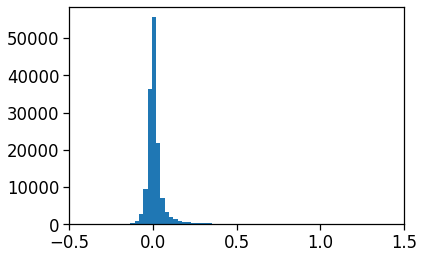

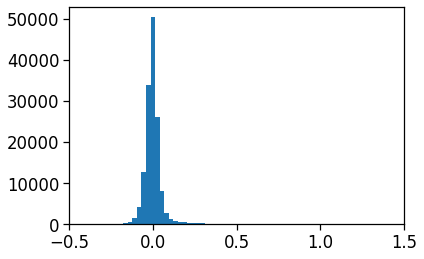

In [ ]:
plt.figure(1)
plt.hist(data.mean_response, bins=200)
plt.xlim(-0.5,1.5)
plt.figure(2)
plt.hist(data.baseline_response, bins=200)
plt.xlim(-0.5,1.5)


#

In [ ]:
#La columna imaging_depth no contiene informacion util. 
sst_data = data[(data.cre_line == 'Sst-IRES-Cre')&(data.is_change == True)]
vip_data = data[(data.cre_line == 'Vip-IRES-Cre')&(data.is_change == True)]
print('Neuronas VIP se encuentran solo en un depth:',vip_data.imaging_depth.unique())
print('Neuronas SST se encuentran solo en un depth:',sst_data.imaging_depth.unique())
print('Neuronas VIP se encuentran en estas regiones:',vip_data.targeted_structure.unique())
print('Neuronas SST se encuentran en estas regiones:',sst_data.targeted_structure.unique())



Neuronas VIP se encuentran solo en un depth: [175]
Neuronas SST se encuentran solo en un depth: [275]
Neuronas VIP se encuentran en estas regiones: ['VISp']
Neuronas SST se encuentran en estas regiones: ['VISp']


In [ ]:
sst_dataC = data[(data.cre_line == 'Sst-IRES-Cre')&(data.is_change == True)]
vip_dataC = data[(data.cre_line == 'Vip-IRES-Cre')&(data.is_change == True)]
sst_dataNC = data[(data.cre_line == 'Sst-IRES-Cre')&(data.is_change == False)]
vip_dataNC = data[(data.cre_line == 'Vip-IRES-Cre')&(data.is_change == False)]
#(data.is_change == False)] = data.omitted==True
print(len(sst_dataNC))
print(len(sst_dataC))
print((len(sst_dataNC)/len(sst_dataC))*100)

25131
34350
0.7316157205240175

25131
34350
73.16157205240175


0.7316157205240175

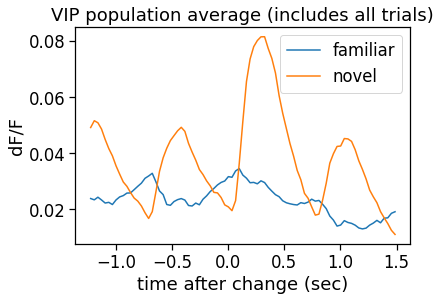

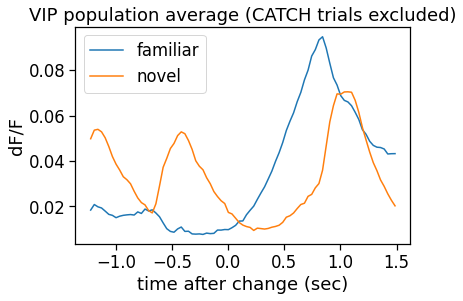

In [ ]:
timestamps = vip_dataC.trace_timestamps.values[0]
for exposure_level in vip_dataC.exposure_level.unique():
  traces = vip_dataC[vip_dataC.exposure_level==exposure_level].trace.values
  plt.plot(timestamps, np.mean(traces), label=exposure_level)
plt.title('VIP population average (includes all trials)')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
plt.legend()
plt.show()

timestamps = vip_dataNC.trace_timestamps.values[0]
for exposure_level in vip_dataNC.exposure_level.unique():
  traces = vip_dataNC[vip_dataNC.exposure_level==exposure_level].trace.values
  plt.plot(timestamps, np.mean(traces), label=exposure_level)
plt.title('VIP population average (CATCH trials excluded)')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
plt.legend()
plt.show()

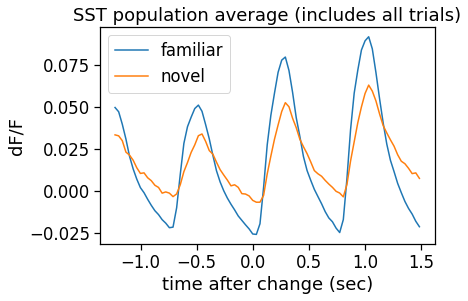

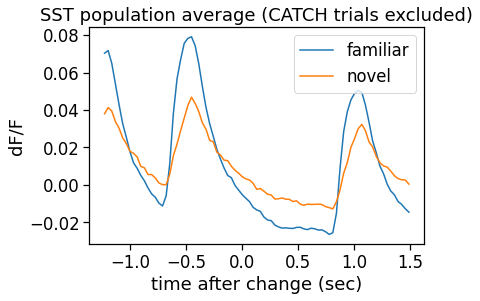

In [ ]:
timestamps = sst_dataC.trace_timestamps.values[0]
for exposure_level in sst_dataC.exposure_level.unique():
  traces = sst_dataC[sst_dataC.exposure_level==exposure_level].trace.values
  plt.plot(timestamps, np.mean(traces), label=exposure_level)
  #plt.plot(timestamps, np.mean(traces)+np.std(traces) / np.sqrt(np.size(traces)))
  #np.std(traces, ddof=1) / np.sqrt(np.size(traces))
  #print(x)
plt.title('SST population average (includes all trials)')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
plt.legend()
plt.show()

timestamps = sst_dataNC.trace_timestamps.values[0]
for exposure_level in sst_dataNC.exposure_level.unique():
  traces = sst_dataNC[sst_dataNC.exposure_level==exposure_level].trace.values
  plt.plot(timestamps, np.mean(traces), label=exposure_level)
plt.title('SST population average (CATCH trials excluded)')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
plt.legend()
plt.show()

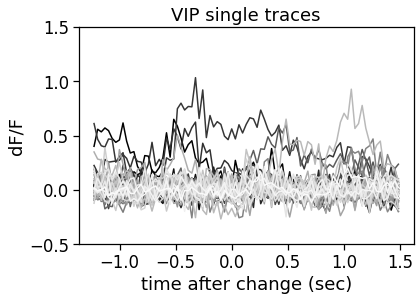

In [ ]:
timestamps = vip_dataNC.trace_timestamps.values[0]
step=500
offset = 1 / (len(vip_dataC[vip_dataC.exposure_level=='novel'].trace.values)/step)
color = [0, 0, 0]
for i in range(1,len(vip_dataC[vip_dataC.exposure_level=='novel'].trace.values),step):
  traces = vip_dataC[vip_dataC.exposure_level=='novel'].trace.values
  plt.plot(timestamps,traces[i],color = color)
  color = [color[0] + offset, color[1] + offset, color[2] + offset]
 
plt.title('VIP single traces')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
plt.ylim(-0.5,1.5)
#plt.legend()
plt.show()



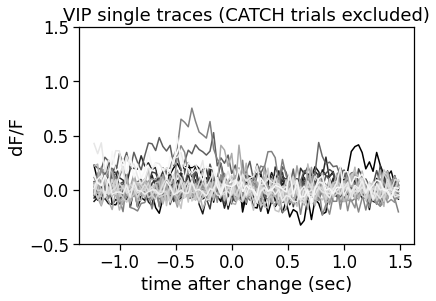

In [ ]:
timestamps = vip_dataNC.trace_timestamps.values[0]
step=500
offset = 1 / (len(vip_dataNC[vip_dataNC.exposure_level=='novel'].trace.values)/step)
color = [0, 0, 0]
for i in range(1,len(vip_dataNC[vip_dataNC.exposure_level=='novel'].trace.values),step):
  traces = vip_dataNC[vip_dataNC.exposure_level=='novel'].trace.values
  plt.plot(timestamps,traces[i], color = color)
  color = [color[0] + offset, color[1] + offset, color[2] + offset]
 
plt.title('VIP single traces (CATCH trials excluded)')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
plt.ylim(-0.5,1.5)
#plt.legend()
plt.show()

### Comparing No change to omitted Data

In [ ]:
vip_no_change = data[(data.cre_line == 'Vip-IRES-Cre')&(data.is_change == False)]
vip_omitted = data[(data.cre_line == 'Vip-IRES-Cre')&(data.omitted == True)]

In [ ]:
vip_no_change.equals(vip_omitted)

True

In [ ]:
sst_no_change = data[(data.cre_line == 'Sst-IRES-Cre')&(data.is_change == False)]
sst_omitted = data[(data.cre_line == 'Sst-IRES-Cre')&(data.omitted == True)]

In [ ]:
sst_no_change.equals(sst_omitted)

True

# Matriz de confusión

In [ ]:
vip_true_pos = data[(data.cre_line == 'Vip-IRES-Cre') & data.is_change & (data.response_latency.notna())]
vip_false_neg = data[(data.cre_line == 'Vip-IRES-Cre') & data.is_change & (data.response_latency.isna())]
vip_true_neg = data[(data.cre_line == 'Vip-IRES-Cre') & ~(data.is_change) & (data.response_latency.isna())]
vip_false_pos = data[(data.cre_line == 'Vip-IRES-Cre') & ~(data.is_change) & (data.response_latency.notna())]
sst_true_pos =  data[(data.cre_line == 'Sst-IRES-Cre') & data.is_change & (data.response_latency.notna())]

In [ ]:
sst_data = data[(data.cre_line == 'Sst-IRES-Cre')]
vip_data = data[(data.cre_line == 'Vip-IRES-Cre')]
vip_data_change = data[(data.cre_line == 'Vip-IRES-Cre')&(data.is_change == True)]
sst_data_catch = data[(data.cre_line == 'Sst-IRES-Cre')&(data.is_change == False)]
vip_data_catch = data[(data.cre_line == 'Vip-IRES-Cre')&(data.is_change == False)]

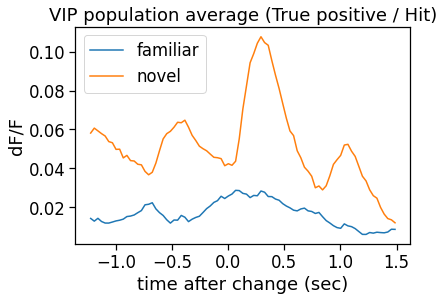

In [ ]:
timestamps = vip_true_pos.trace_timestamps.values[0]  # trace timestamps are relative to stimulus onset
for exposure_level in vip_true_pos.exposure_level.unique():
  traces = vip_true_pos[vip_true_pos.exposure_level == exposure_level].trace.values
  plt.plot(timestamps, np.mean(traces), label=exposure_level)
plt.title('VIP population average (True positive / Hit)')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
plt.legend()
plt.show()

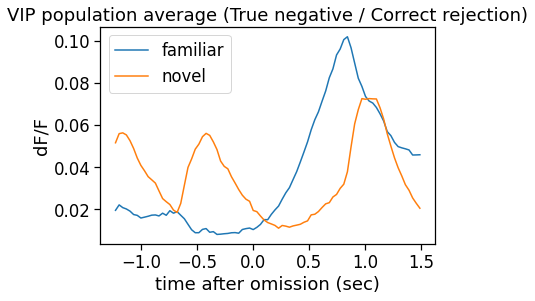

In [ ]:
timestamps = vip_true_neg.trace_timestamps.values[0]  # trace timestamps are relative to stimulus onset
for exposure_level in vip_true_neg.exposure_level.unique():
  traces = vip_true_neg[vip_true_neg.exposure_level == exposure_level].trace.values
  plt.plot(timestamps, np.mean(traces), label=exposure_level)
plt.title('VIP population average (True negative / Correct rejection)')
plt.xlabel('time after omission (sec)')
plt.ylabel('dF/F')
plt.legend()
plt.show()

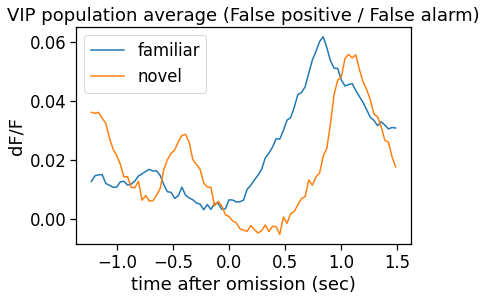

In [ ]:
timestamps = vip_false_pos.trace_timestamps.values[0]  # trace timestamps are relative to stimulus onset
for exposure_level in vip_false_pos.exposure_level.unique():
  traces = vip_false_pos[vip_false_pos.exposure_level == exposure_level].trace.values
  plt.plot(timestamps, np.mean(traces), label=exposure_level)
plt.title('VIP population average (False positive / False alarm)')
plt.xlabel('time after omission (sec)')
plt.ylabel('dF/F')
plt.legend()
plt.show()

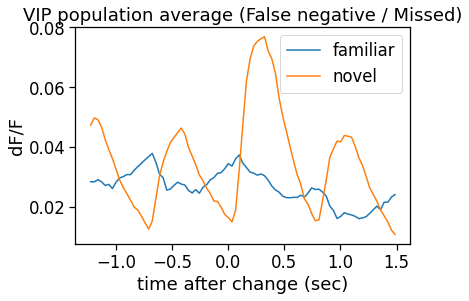

In [ ]:
timestamps = vip_false_neg.trace_timestamps.values[0]  # trace timestamps are relative to stimulus onset
for exposure_level in vip_false_neg.exposure_level.unique():
  traces = vip_false_neg[vip_false_neg.exposure_level == exposure_level].trace.values
  plt.plot(timestamps, np.mean(traces), label=exposure_level)
plt.title('VIP population average (False negative / Missed)')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
plt.legend()
plt.show()

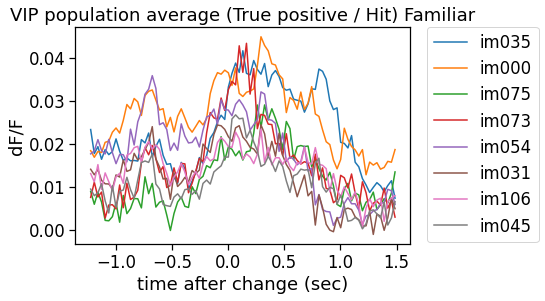

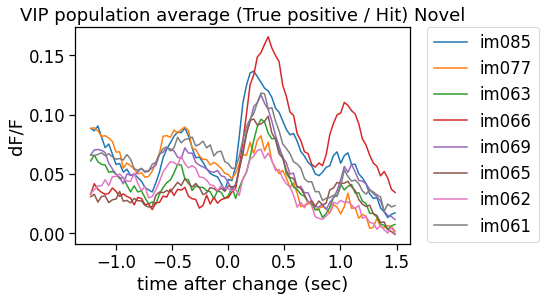

In [ ]:
vip_true_pos_fam = vip_true_pos[vip_true_pos.exposure_level=="familiar"]

timestamps = vip_true_pos_fam.trace_timestamps.values[0]  # trace timestamps are relative to stimulus onset
for image_name in vip_true_pos_fam.image_name.unique():
  traces = vip_true_pos_fam[vip_true_pos_fam.image_name == image_name].trace.values
  plt.plot(timestamps, np.mean(traces), label=image_name)
plt.title('VIP population average (True positive / Hit) Familiar')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

vip_true_pos_novel = vip_true_pos[vip_true_pos.exposure_level=="novel"]

timestamps = vip_true_pos_novel.trace_timestamps.values[0]  # trace timestamps are relative to stimulus onset
for image_name in vip_true_pos_novel.image_name.unique():
  traces = vip_true_pos_novel[vip_true_pos_novel.image_name == image_name].trace.values
  plt.plot(timestamps, np.mean(traces), label=image_name)
plt.title('VIP population average (True positive / Hit) Novel')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

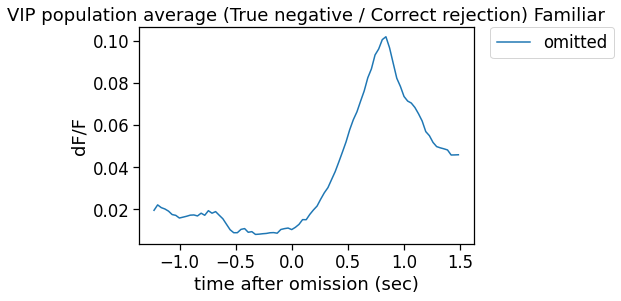

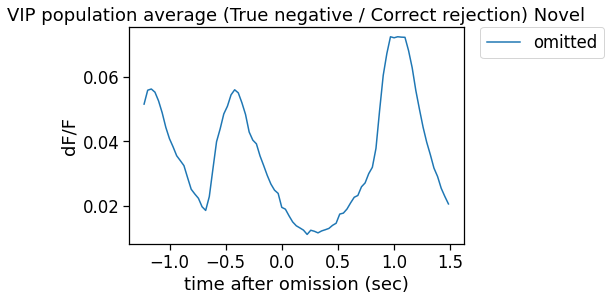

In [ ]:
vip_true_neg_fam = vip_true_neg[vip_true_neg.exposure_level=="familiar"]

timestamps = vip_true_neg_fam.trace_timestamps.values[0]  # trace timestamps are relative to stimulus onset
for image_name in vip_true_neg_fam.image_name.unique():
  traces = vip_true_neg_fam[vip_true_neg_fam.image_name == image_name].trace.values
  plt.plot(timestamps, np.mean(traces), label=image_name)
plt.title('VIP population average (True negative / Correct rejection) Familiar')
plt.xlabel('time after omission (sec)')
plt.ylabel('dF/F')
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

vip_true_neg_novel = vip_true_neg[vip_true_neg.exposure_level=="novel"]

timestamps = vip_true_neg_novel.trace_timestamps.values[0]  # trace timestamps are relative to stimulus onset
for image_name in vip_true_neg_novel.image_name.unique():
  traces = vip_true_neg_novel[vip_true_neg_novel.image_name == image_name].trace.values
  plt.plot(timestamps, np.mean(traces), label=image_name)
plt.title('VIP population average (True negative / Correct rejection) Novel')
plt.xlabel('time after omission (sec)')
plt.ylabel('dF/F')
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

5549


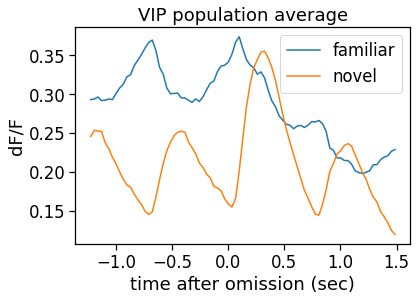

In [ ]:
threshold = 0.4

vip_t = vip_data_change[vip_data_change.trace.apply(lambda a: a > threshold).apply(lambda a: np.any(a))]
print(len(vip_t))

timestamps = vip_t.trace_timestamps.values[0]  # trace timestamps are relative to stimulus onset
for exposure_level in vip_t.exposure_level.unique():
  traces = vip_t[vip_t.exposure_level == exposure_level].trace.values
  plt.plot(timestamps, np.mean(traces), label=exposure_level)
plt.title('VIP population average')
plt.xlabel('time after omission (sec)')
plt.ylabel('dF/F')
plt.legend()
plt.show()

Para PCA (en progreso) solo analysis de VIP versus SST para la poblacion entera

In [ ]:
# @title Helper Functions

def add_noise(X, frac_noisy_pixels):
  """
  Randomly corrupts a fraction of the pixels by setting them to random values.

  Args:
     X (numpy array of floats)  : Data matrix
     frac_noisy_pixels (scalar) : Fraction of noisy pixels

  Returns:
     (numpy array of floats)    : Data matrix + noise

  """

  X_noisy = np.reshape(X, (X.shape[0] * X.shape[1]))
  N_noise_ixs = int(X_noisy.shape[0] * frac_noisy_pixels)
  noise_ixs = np.random.choice(X_noisy.shape[0], size=N_noise_ixs,
                               replace=False)
  X_noisy[noise_ixs] = np.random.uniform(0, 255, noise_ixs.shape)
  X_noisy = np.reshape(X_noisy, (X.shape[0], X.shape[1]))

  return X_noisy


def change_of_basis(X, W):
  """
  Projects data onto a new basis.

  Args:
    X (numpy array of floats) : Data matrix each column corresponding to a
                                different random variable
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors

  Returns:
    (numpy array of floats)   : Data matrix expressed in new basis
  """

  Y = np.matmul(X, W)

  return Y


def get_sample_cov_matrix(X):
  """
  Returns the sample covariance matrix of data X.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

  Returns:
    (numpy array of floats)   : Covariance matrix
"""

  X = X - np.mean(X, 0)
  cov_matrix = 1 / X.shape[0] * np.matmul(X.T, X)
  return cov_matrix


def sort_evals_descending(evals, evectors):
  """
  Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
  eigenvectors to be in first two quadrants (if 2D).

  Args:
    evals (numpy array of floats)    :   Vector of eigenvalues
    evectors (numpy array of floats) :   Corresponding matrix of eigenvectors
                                         each column corresponds to a different
                                         eigenvalue

  Returns:
    (numpy array of floats)          : Vector of eigenvalues after sorting
    (numpy array of floats)          : Matrix of eigenvectors after sorting
  """

  index = np.flip(np.argsort(evals))
  evals = evals[index]
  evectors = evectors[:, index]
  if evals.shape[0] == 2:
    if np.arccos(np.matmul(evectors[:, 0],
                           1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
      evectors[:, 0] = -evectors[:, 0]
    if np.arccos(np.matmul(evectors[:, 1],
                           1 / np.sqrt(2)*np.array([-1, 1]))) > np.pi / 2:
      evectors[:, 1] = -evectors[:, 1]

  return evals, evectors


def pca(X):
  """
  Performs PCA on multivariate data. Eigenvalues are sorted in decreasing order

  Args:
     X (numpy array of floats) :   Data matrix each column corresponds to a
                                   different random variable

  Returns:
    (numpy array of floats)    : Data projected onto the new basis
    (numpy array of floats)    : Corresponding matrix of eigenvectors
    (numpy array of floats)    : Vector of eigenvalues

  """

  X = X - np.mean(X, 0)
  cov_matrix = get_sample_cov_matrix(X)
  evals, evectors = np.linalg.eigh(cov_matrix)
  evals, evectors = sort_evals_descending(evals, evectors)
  score = change_of_basis(X, evectors)

  return score, evectors, evals

In [ ]:
# @title Plotting Functions

def plot_variance_explained(variance_explained):
  """
  Plots eigenvalues.

  Args:
    variance_explained (numpy array of floats) : Vector of variance explained
                                                 for each PC

  Returns:
    Nothing.

  """

  plt.figure()
  plt.plot(np.arange(1, len(variance_explained) + 1), variance_explained,
           '--k')
  plt.xlabel('Number of components')
  plt.ylabel('Variance explained')
  plt.show()


def plot_MNIST_reconstruction(X, X_reconstructed):
  """
  Plots 9 images in the MNIST dataset side-by-side with the reconstructed
  images.

  Args:
    X (numpy array of floats)               : Data matrix each column
                                              corresponds to a different
                                              random variable
    X_reconstructed (numpy array of floats) : Data matrix each column
                                              corresponds to a different
                                              random variable

  Returns:
    Nothing.
  """

  plt.figure()
  ax = plt.subplot(121)
  k = 0
  for k1 in range(3):
    for k2 in range(3):
      k = k + 1
      plt.imshow(np.reshape(X[k, :], (28, 28)),
                 extent=[(k1 + 1) * 28, k1 * 28, (k2 + 1) * 28, k2 * 28],
                 vmin=0, vmax=255)
  plt.xlim((3 * 28, 0))
  plt.ylim((3 * 28, 0))
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.title('Data')
  plt.clim([0, 250])
  ax = plt.subplot(122)
  k = 0
  for k1 in range(3):
    for k2 in range(3):
      k = k + 1
      plt.imshow(np.reshape(np.real(X_reconstructed[k, :]), (28, 28)),
                 extent=[(k1 + 1) * 28, k1 * 28, (k2 + 1) * 28, k2 * 28],
                 vmin=0, vmax=255)
  plt.xlim((3 * 28, 0))
  plt.ylim((3 * 28, 0))
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.clim([0, 250])
  plt.title('Reconstructed')
  plt.tight_layout()


def plot_MNIST_sample(X):
  """
  Plots 9 images in the MNIST dataset.

  Args:
     X (numpy array of floats) : Data matrix each column corresponds to a
                                 different random variable

  Returns:
    Nothing.

  """

  fig, ax = plt.subplots()
  k = 0
  for k1 in range(3):
    for k2 in range(3):
      k = k + 1
      plt.imshow(np.reshape(X[k, :], (28, 28)),
                 extent=[(k1 + 1) * 28, k1 * 28, (k2+1) * 28, k2 * 28],
                 vmin=0, vmax=255)
  plt.xlim((3 * 28, 0))
  plt.ylim((3 * 28, 0))
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  plt.clim([0, 250])
  ax.set_xticks([])
  ax.set_yticks([])
  plt.show()


def plot_eigenvalues(evals, limit=True):
  """
  Plots eigenvalues.

  Args:
     (numpy array of floats) : Vector of eigenvalues

  Returns:
    Nothing.

  """

  plt.figure()
  plt.plot(np.arange(1, len(evals) + 1), evals, 'o-k')
  plt.xlabel('Component')
  plt.ylabel('Eigenvalue')
  plt.title('Scree plot')
  if limit:
    plt.show()

# @title Plotting Functions

def visualize_components(component1, component2, labels, show=True):
  """
  Plots a 2D representation of the data for visualization with categories
  labelled as different colors.

  Args:
    component1 (numpy array of floats) : Vector of component 1 scores
    component2 (numpy array of floats) : Vector of component 2 scores
    labels (numpy array of floats)     : Vector corresponding to categories of
                                         samples

  Returns:
    Nothing.

  """

  plt.figure()
  #cmap = plt.cm.get_cmap('tab10')
  plt.scatter(x=component1, y=component2, c=labels)
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.colorbar(ticks=range(8))
  plt.clim(0, 7)
  if show:
    plt.show()

In [ ]:
gab=np.array(vip_gab_gr)
score, evectors, evals = pca(gab[:,:-1])
plot_eigenvalues(evals, limit=False)
plt.xlim(0,21)  # limit x-axis up to 100 for zooming
#X, labels = neX[:2000, :], labels_all[:2000]
X, labels=gab[:,:-1],gab[:,-1]
visualize_components(score[:, 0], score[:,1],labels)

# 0 = SST; 1=VIP

NameError: ignored

In [ ]:
 j=score[:,0:3]
 from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, perplexity=20, random_state=2020)

embed = tsne_model.fit_transform(gab[:,:-1])

# Visualize the data
with plt.xkcd():
  visualize_components(embed[:, 0], embed[:, 1], labels)

In [ ]:
from numpy.ma.core import mean

#for i in range (len(gab.T)):
#  for i in range (len(vip_gab_gr.image_index.unique())):
yind=0
rows, cols = (1, 1)
neuron = []
#neuron=np.array(0,0)
for i in range (len(gab)):
 if gab[i,-1]==0:

  neuron.append(gab[i,0])
  #yind=yind+1


np.mean(neuron)
np.std(neuron)/np.sqrt(np.count_nonzero(neuron))


  #x=x+1

#for i, stimulus_presentations_id in enumerate(cell_data.stimulus_presentations_id.unique()):
 # trial_data = cell_data[cell_data.stimulus_presentations_id == stimulus_presentations_id]
  #timestamps = trial_data.trace_timestamps.values[0]
  #trace = trial_data.trace.values[0]
  #plt.plot(timestamps, trace, color = color)
  #color = [color[0] + offset, color[1] + offset, color[2] + offset]
#plt.title(f'cell_specimen_id:{example_cell_specimen_id}')
#plt.xlabel('time after change (sec)')
#plt.ylabel('dF/F')
#plt.show()

In [ ]:
len(vip_gab_gr.image_index.unique())
print(gab[0,0])

In [ ]:
#vip_gab.groupby(['cell_specimen_id']).size().reset_index().rename(columns={0:'count'})
#vip_gab = data[(data.mouse_id=="476970") & (data.ophys_session_id==994199725)]

#vip_gab.groupby(['cell_specimen_id']).size().reset_index().rename(columns={0:'count'})
vip_gab = vip_true_pos[(vip_true_pos.mouse_id=="467953") & (vip_true_pos.ophys_session_id==967965969)]

i = 0
for cell in vip_gab.cell_specimen_id.unique(): # 0 - 17
    vip_gab["Neuron_" + str(i)] = vip_gab[vip_gab.cell_specimen_id==cell]["mean_response"]
    i += 1

vip_gab

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,image_name,image_index,is_change,omitted,...,Neuron_12,Neuron_13,Neuron_14,Neuron_15,Neuron_16,Neuron_17,Neuron_18,Neuron_19,Neuron_20,Neuron_21
404083,11,1086495458,"[2.6226894855499268, 2.74231219291687, 2.44449...","[-1.2281917066763746, -1.195870872290154, -1.1...",2.540670,2.312487,im085,6,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
404084,11,1086495538,"[0.40129730105400085, 0.5581840872764587, 0.53...","[-1.2281917066763746, -1.195870872290154, -1.1...",0.152101,0.095508,im085,6,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
404085,11,1086495170,"[1.1457717418670654, 0.9389017820358276, 0.919...","[-1.2281917066763746, -1.195870872290154, -1.1...",0.302181,0.447689,im085,6,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
404086,11,1086497993,"[0.012399504892528057, 0.19427867233753204, 0....","[-1.2281917066763746, -1.195870872290154, -1.1...",0.246993,-0.055034,im085,6,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
404087,11,1086496225,"[1.2880990505218506, 1.276120662689209, 1.3052...","[-1.2281917066763746, -1.195870872290154, -1.1...",1.164615,0.794078,im085,6,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488558,3850,1086496921,"[0.26936259865760803, 0.2739019989967346, 0.40...","[-1.2281917066763746, -1.195870872290154, -1.1...",0.250982,0.250878,im063,4,True,False,...,NaN,NaN,NaN,NaN,NaN,0.250982,NaN,NaN,NaN,NaN
488559,3850,1086496472,"[0.06689877808094025, -0.01110783126205206, -0...","[-1.2281917066763746, -1.195870872290154, -1.1...",0.026786,-0.001868,im063,4,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,0.026786,NaN,NaN,NaN
488560,3850,1086497031,"[0.05627351626753807, -0.07050620764493942, 0....","[-1.2281917066763746, -1.195870872290154, -1.1...",0.339346,0.162990,im063,4,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.339346,NaN,NaN
488561,3850,1086497149,"[0.5077157020568848, 0.5405912399291992, 0.494...","[-1.2281917066763746, -1.195870872290154, -1.1...",0.214112,0.234689,im063,4,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.214112,NaN


In [ ]:
columnas = ['trace', 'trace_timestamps', 'mean_response', 'baseline_response', 'image_name', 'mean_running_speed', 'mean_pupil_area', 'response_latency', 'rewarded', 'imaging_depth', 'targeted_structure', 'session_type', 'exposure_level']
sst_data_new = sst_dataC[columnas]
vip_dataC_new = vip_dataC[columnas]
sst_dataNC_new = sst_dataNC[columnas]
vip_dataNC_new = vip_dataNC[columnas]

## Summary by Trials

In [ ]:
sst_data = data[(data.cre_line == 'Sst-IRES-Cre')].copy()
vip_data = data[(data.cre_line == 'Vip-IRES-Cre')].copy()
vip_data_change = data[(data.cre_line == 'Vip-IRES-Cre')&(data.is_change == True)].copy()
sst_data_change = data[(data.cre_line == 'Sst-IRES-Cre')&(data.is_change == True)].copy()
sst_data_no_change = data[(data.cre_line == 'Sst-IRES-Cre')&(data.is_change == False)].copy()
vip_data_no_change = data[(data.cre_line == 'Vip-IRES-Cre')&(data.is_change == False)].copy()

In [ ]:
vip_data_change.groupby(['mouse_id', 'stimulus_presentations_id']).size().reset_index().rename(columns={0:'count'})
# Find mean response by neuron and image**********

,mouse_id,stimulus_presentations_id,count
0,467951,35,17
1,467951,74,17
2,467951,88,17
3,467951,99,17
4,467951,143,17
...,...,...,...
2716,492395,4764,25
2717,492395,4771,59
2718,492395,4775,25
2719,492395,4785,49


In [ ]:
vdc_g = vip_data_change.groupby(['mouse_id', 'image_index', 'stimulus_presentations_id'], as_index=False).agg({
    'mean_response': ['mean', 'std'],
    'response_latency': 'mean', 
    'age_in_days': 'first',
    'exposure_level': 'first',
    'sex': 'first'
})

# vdc_g

### mean_response / baseline_response
### mean_response - baseline_response
print(vdc_g)

     mouse_id image_index stimulus_presentations_id mean_response            \
                                                             mean       std   
0      467951           0                        74      0.005801  0.015444   
1      467951           0                       155      0.013126  0.047021   
2      467951           0                       656      0.004577  0.014095   
3      467951           0                      1074      0.003722  0.018781   
4      467951           0                      1280      0.009273  0.012547   
...       ...         ...                       ...           ...       ...   
2800   492395           7                      4580      0.007609  0.018021   
2801   492395           7                      4657      0.001497  0.021288   
2802   492395           7                      4685      0.026205  0.121676   
2803   492395           7                      4754      0.122730  0.309559   
2804   492395           7                      4775 

In [ ]:
#vip_gab.groupby(['cell_specimen_id']).size().reset_index().rename(columns={0:'count'})
vip_gab = vip_true_pos[(vip_true_pos.mouse_id=="467953") & (vip_true_pos.ophys_session_id==967965969)]

i = 0
for cell in vip_gab.cell_specimen_id.unique(): # 0 - 17
    vip_gab["Neuron_" + str(i)] = vip_gab[vip_gab.cell_specimen_id==cell]["mean_response"]
    i += 1

vip_gab

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,image_name,image_index,is_change,omitted,...,Neuron_12,Neuron_13,Neuron_14,Neuron_15,Neuron_16,Neuron_17,Neuron_18,Neuron_19,Neuron_20,Neuron_21
404083,11,1086495458,"[2.6226894855499268, 2.74231219291687, 2.44449...","[-1.2281917066763746, -1.195870872290154, -1.1...",2.540670,2.312487,im085,6,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
404084,11,1086495538,"[0.40129730105400085, 0.5581840872764587, 0.53...","[-1.2281917066763746, -1.195870872290154, -1.1...",0.152101,0.095508,im085,6,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
404085,11,1086495170,"[1.1457717418670654, 0.9389017820358276, 0.919...","[-1.2281917066763746, -1.195870872290154, -1.1...",0.302181,0.447689,im085,6,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
404086,11,1086497993,"[0.012399504892528057, 0.19427867233753204, 0....","[-1.2281917066763746, -1.195870872290154, -1.1...",0.246993,-0.055034,im085,6,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
404087,11,1086496225,"[1.2880990505218506, 1.276120662689209, 1.3052...","[-1.2281917066763746, -1.195870872290154, -1.1...",1.164615,0.794078,im085,6,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488558,3850,1086496921,"[0.26936259865760803, 0.2739019989967346, 0.40...","[-1.2281917066763746, -1.195870872290154, -1.1...",0.250982,0.250878,im063,4,True,False,...,NaN,NaN,NaN,NaN,NaN,0.250982,NaN,NaN,NaN,NaN
488559,3850,1086496472,"[0.06689877808094025, -0.01110783126205206, -0...","[-1.2281917066763746, -1.195870872290154, -1.1...",0.026786,-0.001868,im063,4,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,0.026786,NaN,NaN,NaN
488560,3850,1086497031,"[0.05627351626753807, -0.07050620764493942, 0....","[-1.2281917066763746, -1.195870872290154, -1.1...",0.339346,0.162990,im063,4,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.339346,NaN,NaN
488561,3850,1086497149,"[0.5077157020568848, 0.5405912399291992, 0.494...","[-1.2281917066763746, -1.195870872290154, -1.1...",0.214112,0.234689,im063,4,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.214112,NaN


In [ ]:
vip_gab_gr = vip_gab.groupby(["stimulus_presentations_id"]).agg(lambda a: a.mean(skipna=True)).reset_index()[[
    "Neuron_0", 
    "Neuron_1", 
    "Neuron_2", 
    "Neuron_3", 
    "Neuron_4", 
    "Neuron_5", 
    "Neuron_6", 
    "Neuron_7", 
    "Neuron_8", 
    "Neuron_9", 
    "Neuron_10", 
    "Neuron_11", 
    "Neuron_12", 
    "Neuron_13", 
    "Neuron_14", 
    "Neuron_15",
    "Neuron_16",
    "Neuron_17",
    "Neuron_18",
    "Neuron_19",
    "Neuron_20",
    "Neuron_21",
    "image_index"
]]

vip_gab_gr

/usr/local/lib/python3.7/dist-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


,Neuron_0,Neuron_1,Neuron_2,Neuron_3,Neuron_4,Neuron_5,Neuron_6,Neuron_7,Neuron_8,Neuron_9,...,Neuron_13,Neuron_14,Neuron_15,Neuron_16,Neuron_17,Neuron_18,Neuron_19,Neuron_20,Neuron_21,image_index
0,2.540670,0.152101,0.302181,0.246993,1.164615,1.295363,0.489712,0.373417,0.662712,0.934227,...,0.017166,0.300186,0.017270,0.195701,0.113135,0.046685,0.100564,0.089522,0.028665,6.0
1,2.394534,0.615008,0.047520,0.150070,0.265049,0.296495,1.056455,0.236920,0.441517,0.900106,...,-0.004346,0.518454,0.003779,0.031073,0.050808,0.055168,0.049452,0.011185,0.006011,1.0
2,0.678724,0.085234,0.088322,0.017938,0.385431,0.005229,0.770742,0.311975,-0.017965,0.553040,...,-0.027643,0.264346,0.077503,0.024055,0.059839,0.016305,0.079316,0.053218,0.042461,4.0
3,0.121904,0.124705,0.087998,0.077677,0.204022,0.026130,0.796645,1.250288,0.037744,0.142385,...,0.034521,0.023789,0.173013,0.064949,0.140618,0.024849,0.139232,0.196602,0.097990,2.0
4,0.464841,0.073060,0.055052,0.076022,0.102151,0.188714,0.546353,0.981828,0.041439,0.607987,...,0.029008,0.021352,0.001535,0.030760,0.031643,0.021867,0.069351,0.014744,0.245472,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0.059049,0.166539,0.057790,0.139377,-0.008969,-0.006652,0.104938,0.002500,0.073784,0.041410,...,0.054723,0.018432,0.074628,0.080727,0.072314,0.026533,0.055751,0.406048,0.098356,3.0
66,0.074141,0.046957,0.100776,0.067111,0.025963,-0.010072,0.021162,0.010574,0.055163,0.023296,...,0.007777,0.037145,0.041973,0.125238,0.018088,0.022684,0.050294,-0.001072,0.090692,0.0
67,0.025593,0.028452,-0.023022,0.051734,0.030590,0.015587,0.214988,0.034460,0.028991,0.029438,...,0.051178,0.000724,0.166108,0.030904,0.037696,0.006710,0.010657,0.042039,0.072678,6.0
68,-0.015527,-0.031631,-0.011711,-0.000052,-0.028741,-0.026145,-0.035975,-0.011246,0.018049,-0.032400,...,-0.020780,-0.026318,-0.004005,-0.003931,-0.015834,-0.017700,-0.029460,-0.026813,-0.014892,1.0


In [ ]:
vdc_g = sst_true_pos.groupby(['mouse_id', 'image_index', 'stimulus_presentations_id'], as_index=False).agg({
    'mean_response': [(lambda gr: gr.mean()), (lambda gr: gr.std())],
    'age_in_days': 'first',
    'exposure_level': 'first',
    'sex': 'first'
})

vdc_g.columns = [' '.join(col).strip() for col in vdc_g.columns.values]
vdc_g.head()

X = vdc_g[vdc_g["exposure_level first"] == "familiar"][["mean_response <lambda_0>", "mean_response <lambda_1>"]]
y = vdc_g[vdc_g["exposure_level first"] == "familiar"].loc[:, "image_index"]

# PCA


In [ ]:
# Combining Logistic and PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter = 1000)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report






## Variables

In [ ]:
# Defino features (VI) and targets
features = [i for i in vip_gab_gr if i not in 'image_index'] #Selecciono todas las columnas que no sean image_index
features = vip_gab_gr[features] #selecciono esas columnas que contengan los datos (rows)
target = vip_gab_gr['image_index'] #selecciono la variable de interés para clasificar
target 


0     6.0
1     1.0
2     4.0
3     2.0
4     7.0
     ... 
65    3.0
66    0.0
67    6.0
68    1.0
69    4.0
Name: image_index, Length: 70, dtype: float64

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
pca_components = pca.fit_transform(scaled_features)

df_with_pca = pd.DataFrame(data = pca_components, columns = ['PCA1', 'PCA2', 'PCA3'])
df_with_pca.head()

final_df_target_pca = pd.concat([df_with_pca, target], axis = 1)

final_df_target_pca



,PCA1,PCA2,PCA3,image_index
0,8.253208,-4.965929,2.865108,6.0
1,2.592020,-4.563256,3.523826,1.0
2,-0.211476,-1.681086,-0.082040,4.0
3,1.640939,0.942761,-1.660107,2.0
4,0.512306,-0.741483,-0.332434,7.0
...,...,...,...,...
65,-0.814984,0.934584,-0.128411,3.0
66,-1.679622,0.340800,0.181219,0.0
67,-1.830115,0.292968,-0.851203,6.0
68,-3.545330,-0.904950,0.205571,1.0


In [ ]:
import plotly.express as px

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}


fig = px.scatter_matrix(
    pca_components,
    labels=labels,
    dimensions=range(3),
    color= target
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [ ]:
total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    pca_components, x=0, y=1, z=2, color= target,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [ ]:
pipe = Pipeline(steps=[("pca", pca), ("logistic", clf)])
param_grid = {
    "pca__n_components": [2, 3, 5, 8, 10],
    "logistic__C": np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(scaled_features, target)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)






Best parameter (CV score=0.214):
{'logistic__C': 21.54434690031882, 'pca__n_components': 8}


In [ ]:
clf = LogisticRegression(max_iter = 1000, C = 21.54434690031882)
pca = pca = PCA(n_components = 8)
pipe = Pipeline(steps=[("pca", pca), ("logistic", clf)])

pipe.fit(scaled_features, target)

Pipeline(steps=[('pca', PCA(n_components=8)),
                ('logistic',
                 LogisticRegression(C=21.54434690031882, max_iter=1000))])

In [ ]:
scaled_predictions = pipe.predict(scaled_features)

print("TRAIN:")
print(classification_report(target, scaled_predictions))



TRAIN:
              precision    recall  f1-score   support

         0.0       0.58      0.64      0.61        11
         1.0       0.64      0.88      0.74         8
         2.0       0.57      0.57      0.57         7
         3.0       0.55      0.60      0.57        10
         4.0       0.45      0.56      0.50         9
         5.0       0.60      0.38      0.46         8
         6.0       0.50      0.50      0.50         8
         7.0       1.00      0.56      0.71         9

    accuracy                           0.59        70
   macro avg       0.61      0.58      0.58        70
weighted avg       0.61      0.59      0.58        70



In [ ]:
scores = cross_val_score(pipe, scaled_features, target, cv = 3)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))



Accuracy: 0.24 (+/- 0.18)


# SST results

In [ ]:
# Resume data
sst_data = data[(data.cre_line == 'Sst-IRES-Cre')].copy()
vip_data = data[(data.cre_line == 'Vip-IRES-Cre')].copy()
vip_data_change = data[(data.cre_line == 'Vip-IRES-Cre')&(data.is_change == True)].copy()
sst_data_change = data[(data.cre_line == 'Sst-IRES-Cre')&(data.is_change == True)].copy()
sst_data_no_change = data[(data.cre_line == 'Sst-IRES-Cre')&(data.is_change == False)].copy()
vip_data_no_change = data[(data.cre_line == 'Vip-IRES-Cre')&(data.is_change == False)].copy()

In [ ]:
sst_data_change.groupby(['mouse_id', 'stimulus_presentations_id']).size().reset_index().rename(columns={0:'count'})
# Find mean response by neuron and image**********


,mouse_id,stimulus_presentations_id,count
0,470784,12,18
1,470784,57,18
2,470784,134,18
3,470784,190,18
4,470784,256,18
...,...,...,...
2479,498972,4719,11
2480,498972,4741,11
2481,498972,4758,11
2482,498972,4789,11


In [ ]:

sst_cg = sst_data_change.groupby(['mouse_id', 'image_index', 'stimulus_presentations_id'], as_index=False).agg({
    'mean_response': ['mean', 'std'],
    'response_latency': 'mean', 
    'age_in_days': 'first',
    'exposure_level': 'first',
    'sex': 'first'
})

# vdc_g

### mean_response / baseline_response
### mean_response - baseline_response
print(sst_cg)

     mouse_id image_index stimulus_presentations_id mean_response            \
                                                             mean       std   
0      470784           0                       716      0.000561  0.037437   
1      470784           0                       793      0.041580  0.140638   
2      470784           0                       840      0.059764  0.186569   
3      470784           0                      1000      0.015545  0.032174   
4      470784           0                      1025      0.011168  0.036508   
...       ...         ...                       ...           ...       ...   
2541   498972           7                      4034      0.013107  0.023975   
2542   498972           7                      4193      0.011140  0.019985   
2543   498972           7                      4369      0.142029  0.390670   
2544   498972           7                      4418      0.006511  0.015797   
2545   498972           7                      4758 

In [ ]:
#vip_gab.groupby(['cell_specimen_id']).size().reset_index().rename(columns={0:'count'})
ssg_gab = sst_true_pos[(sst_true_pos.mouse_id=="476970") & (sst_true_pos.ophys_session_id==994199725)]

i = 0
for cell in ssg_gab.cell_specimen_id.unique(): # 0 - 17
    ssg_gab["Neuron_" + str(i)] = ssg_gab[ssg_gab.cell_specimen_id==cell]["mean_response"]
    i += 1

ssg_gab




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,image_name,image_index,is_change,omitted,...,Neuron_7,Neuron_8,Neuron_9,Neuron_10,Neuron_11,Neuron_12,Neuron_13,Neuron_14,Neuron_15,Neuron_16
85,5,1086496689,"[0.06366926431655884, 0.002476318972185254, -0...","[-1.228133913303992, -1.1958145997959921, -1.1...",0.006115,-0.084113,im075,2,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,5,1086501573,"[0.0637083426117897, 0.0919334813952446, -0.09...","[-1.228133913303992, -1.1958145997959921, -1.1...",-0.018832,-0.025578,im075,2,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,5,1086500533,"[0.0223990511149168, 0.22551870346069336, 0.11...","[-1.228133913303992, -1.1958145997959921, -1.1...",-0.041275,-0.032698,im075,2,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,5,1086497438,"[0.01795899122953415, 0.15271763503551483, 0.0...","[-1.228133913303992, -1.1958145997959921, -1.1...",0.039527,-0.026750,im075,2,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,5,1086497908,"[0.059766266494989395, 0.03602207452058792, 0....","[-1.228133913303992, -1.1958145997959921, -1.1...",-0.006628,-0.039277,im075,2,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80541,4737,1086499479,"[0.014912339858710766, -0.06014576926827431, -...","[-1.228133913303992, -1.1958145997959921, -1.1...",0.022774,0.010425,im031,6,True,False,...,NaN,NaN,NaN,NaN,NaN,0.022774,NaN,NaN,NaN,NaN
80542,4737,1086500121,"[-0.13684527575969696, 0.03377550095319748, -0...","[-1.228133913303992, -1.1958145997959921, -1.1...",-0.000312,-0.067331,im031,6,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.000312,NaN,NaN,NaN
80543,4737,1086499798,"[-0.017482561990618706, -0.025356316938996315,...","[-1.228133913303992, -1.1958145997959921, -1.1...",-0.005156,0.055934,im031,6,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005156,NaN,NaN
80544,4737,1086498977,"[0.006825517863035202, -0.02097063697874546, -...","[-1.228133913303992, -1.1958145997959921, -1.1...",0.038164,0.029050,im031,6,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.038164,NaN


In [ ]:
ssg_gab_gr = ssg_gab.groupby(["stimulus_presentations_id"]).agg(lambda a: a.mean(skipna=True)).reset_index()[[
    "Neuron_0", 
    "Neuron_1", 
    "Neuron_2", 
    "Neuron_3", 
    "Neuron_4", 
    "Neuron_5", 
    "Neuron_6", 
    "Neuron_7", 
    "Neuron_8", 
    "Neuron_9", 
    "Neuron_10", 
    "Neuron_11", 
    "Neuron_12", 
    "Neuron_13", 
    "Neuron_14", 
    "Neuron_15",
    "Neuron_16",
    "image_index"
]]

ssg_gab_gr

# Una mejor forma para no tener que elegirlas

/usr/local/lib/python3.7/dist-packages/pandas/core/groupby/generic.py:303: FutureWarning:

Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.



,Neuron_0,Neuron_1,Neuron_2,Neuron_3,Neuron_4,Neuron_5,Neuron_6,Neuron_7,Neuron_8,Neuron_9,Neuron_10,Neuron_11,Neuron_12,Neuron_13,Neuron_14,Neuron_15,Neuron_16,image_index
0,0.006115,-0.018832,-0.041275,0.039527,-0.006628,0.010061,0.087167,0.001650,-0.003985,0.016455,0.079660,-0.027598,-0.030587,-0.055165,-0.030485,-0.011659,-0.018294,2.0
1,0.030653,0.022307,-0.021233,0.013776,0.089438,0.077453,0.064987,0.032200,0.012529,0.021410,0.102304,-0.012245,-0.007515,0.015116,0.037873,0.019625,0.076954,0.0
2,0.161691,0.048029,0.028350,0.092239,0.272975,0.051112,0.160971,0.085565,0.066632,-0.025417,0.022810,-0.000194,0.080105,-0.017873,0.021582,0.225853,0.032548,5.0
3,0.157321,0.030095,0.138517,0.098554,0.407520,0.114515,0.252817,0.091875,0.124177,0.027317,0.040428,0.081618,0.033913,0.003408,0.057920,0.269704,0.090204,7.0
4,0.074772,0.060255,0.014746,0.066642,0.052509,0.034750,0.034625,0.004432,0.040401,-0.040329,0.237768,-0.001125,0.012153,-0.021465,0.047484,0.022302,-0.009851,2.0
5,0.262091,0.087815,0.068607,0.051020,0.197400,0.041681,0.131097,0.076517,0.084163,-0.034250,0.343042,-0.003353,-0.004388,0.119227,0.062181,0.124457,0.086719,4.0
6,0.038002,0.023786,-0.016113,0.018265,0.010519,0.012988,-0.013780,0.030114,0.013502,-0.066527,0.010747,0.002522,0.021000,0.069697,-0.009824,-0.006317,-0.002904,6.0
7,0.058042,0.002513,0.009750,0.038240,0.021374,0.049716,0.166416,-0.008390,0.018396,0.046664,0.005194,-0.006214,0.036341,-0.031323,-0.030953,0.032176,0.023093,6.0
8,0.018149,0.043538,0.004153,0.040919,-0.016337,-0.030471,0.022702,-0.055695,-0.008948,0.027529,0.177180,-0.016891,0.016125,0.015176,0.030207,-0.019685,0.031198,6.0
9,0.237290,0.094065,0.065876,0.137751,0.048851,0.054662,0.382880,0.114373,-0.007920,-0.011614,0.142355,0.014335,-0.029871,0.029756,0.000404,0.106773,0.066122,3.0


In [ ]:
# Defino features (VI) and targets
features_sst = [i for i in ssg_gab_gr if i not in 'image_index'] #Selecciono todas las columnas que no sean image_index
features_sst = ssg_gab_gr[features_sst] #selecciono esas columnas que contengan los datos (rows)
target_sst = ssg_gab_gr['image_index'] #selecciono la variable de interés para clasificar
target_sst 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features_ssg = scaler.fit_transform(features_sst)

pipe_sst = Pipeline(steps=[("pca", pca), ("logistic", clf)])
param_grid = {
    "pca__n_components": [2, 3, 5, 8, 10],
    "logistic__C": np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(scaled_features_ssg, target_sst)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)






/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=5.



Best parameter (CV score=0.400):
{'logistic__C': 0.046415888336127774, 'pca__n_components': 8}


In [ ]:
clf_sst = LogisticRegression(max_iter = 1000, C = 0.400)
pca = pca = PCA(n_components = 8)
pipe = Pipeline(steps=[("pca", pca), ("logistic", clf_sst)])

pipe_sst.fit(scaled_features_ssg, target_sst)

scaled_predictions_sst_ssg = pipe_sst.predict(scaled_features_ssg)

print("TRAIN:")
print(classification_report(target_sst, scaled_predictions_sst_ssg))



TRAIN:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         3
         1.0       1.00      1.00      1.00         2
         2.0       1.00      1.00      1.00         4
         3.0       1.00      1.00      1.00         4
         4.0       1.00      1.00      1.00         2
         5.0       1.00      1.00      1.00         2
         6.0       1.00      1.00      1.00         5
         7.0       1.00      1.00      1.00         3

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



## Familiar vs. Novel

In [ ]:
vip_data_change['mean_baseline_neuron_session'] = vip_data_change.groupby(["cell_specimen_id", "ophys_session_id"])['baseline_response'].transform('mean')
vip_data_change['std_baseline_neuron_session'] = vip_data_change.groupby(["cell_specimen_id", "ophys_session_id"])['baseline_response'].transform('std')

sst_data_change['mean_baseline_neuron_session'] = sst_data_change.groupby(["cell_specimen_id", "ophys_session_id"])['baseline_response'].transform('mean')
sst_data_change['std_baseline_neuron_session'] = sst_data_change.groupby(["cell_specimen_id", "ophys_session_id"])['baseline_response'].transform('std')

In [ ]:
vip_data_change.loc[:, "diff_mean_response"] = vip_data_change.loc[:, "mean_response"] - vip_data_change.loc[:, "baseline_response"]
vip_data_change.loc[:, "div_mean_response"] = vip_data_change.loc[:, "mean_response"] / vip_data_change.loc[:, "baseline_response"]
vip_data_change.loc[:, "zscore_mean_response"] = (vip_data_change.loc[:, "mean_response"] - vip_data_change.loc[:, "mean_baseline_neuron_session"]) / vip_data_change.loc[:, "std_baseline_neuron_session"] ## por neurona y todos los trials


sst_data_change.loc[:, "diff_mean_response"] = sst_data_change.loc[:, "mean_response"] - sst_data_change.loc[:, "baseline_response"]
sst_data_change.loc[:, "div_mean_response"] = sst_data_change.loc[:, "mean_response"] / sst_data_change.loc[:, "baseline_response"]
sst_data_change.loc[:, "zscore_mean_response"] = (sst_data_change.loc[:, "mean_response"] - sst_data_change.loc[:, "mean_baseline_neuron_session"]) / sst_data_change.loc[:, "std_baseline_neuron_session"] ## por neurona y todos los trials

In [ ]:
vip_familiar_novel = vip_data_change.groupby(['mouse_id', 'cell_specimen_id']).filter(lambda x: {'familiar', 'novel'}.issubset(x['exposure_level']))
print(vip_familiar_novel.shape)
vip_familiar_novel.head(1)

(34501, 36)


,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,image_name,image_index,is_change,omitted,...,driver_line,indicator,sex,age_in_days,exposure_level,mean_baseline_neuron_session,std_baseline_neuron_session,diff_mean_response,div_mean_response,zscore_mean_response
303020,10,1086495458,"[0.24749350547790527, 0.06917169690132141, 0.1...","[-1.2281102725749526, -1.1957915811914013, -1....",-0.004352,-0.065662,im075,2,True,False,...,[Vip-IRES-Cre],GCaMP6f,M,182.0,familiar,0.107939,0.34,0.06131,0.066281,-0.330267


In [ ]:
#vip_gab.groupby(['cell_specimen_id']).size().reset_index().rename(columns={0:'count'})
vip_gab = vip_familiar_novel[(vip_familiar_novel.mouse_id=="467953")]

i = 0
for cell in vip_gab.cell_specimen_id.unique(): # 0 - 17
    vip_gab["Neuron_" + str(i)] = vip_gab[vip_gab.cell_specimen_id==cell]["zscore_mean_response"]
    i += 1

vip_gab

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,image_name,image_index,is_change,omitted,...,Neuron_3,Neuron_4,Neuron_5,Neuron_6,Neuron_7,Neuron_8,Neuron_9,Neuron_10,Neuron_11,Neuron_12
303020,10,1086495458,"[0.24749350547790527, 0.06917169690132141, 0.1...","[-1.2281102725749526, -1.1957915811914013, -1....",-0.004352,-0.065662,im075,2,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
303021,10,1086495538,"[0.04483708739280701, 0.16087880730628967, 0.1...","[-1.2281102725749526, -1.1957915811914013, -1....",0.003805,0.012697,im075,2,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
303022,10,1086495170,"[-0.061705004423856735, 0.004823641385883093, ...","[-1.2281102725749526, -1.1957915811914013, -1....",0.016172,-0.002994,im075,2,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
303024,10,1086495264,"[0.2321443259716034, -0.09992679953575134, -0....","[-1.2281102725749526, -1.1957915811914013, -1....",0.031874,0.096516,im075,2,True,False,...,0.365097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
303025,10,1086496225,"[0.3805277943611145, 0.30360355973243713, 0.20...","[-1.2281102725749526, -1.1957915811914013, -1....",0.031077,0.160749,im075,2,True,False,...,NaN,-0.071779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509322,4794,1086496547,"[0.04218181222677231, -0.014531807042658329, 0...","[-1.2281917066763746, -1.195870872290154, -1.1...",-0.019192,0.053834,im061,3,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.494974,NaN,NaN,NaN
509323,4794,1086496681,"[0.017809538170695305, -0.04761819168925285, -...","[-1.2281917066763746, -1.195870872290154, -1.1...",-0.007864,0.013063,im061,3,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.352475,NaN,NaN
509325,4794,1086496844,"[0.14139282703399658, -0.030759267508983612, 0...","[-1.2281917066763746, -1.195870872290154, -1.1...",0.009363,0.005468,im061,3,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.272486
509327,4794,1086496472,"[0.04218519851565361, 0.03812626749277115, 0.0...","[-1.2281917066763746, -1.195870872290154, -1.1...",-0.008488,-0.015968,im061,3,True,False,...,NaN,NaN,NaN,NaN,NaN,-0.397875,NaN,NaN,NaN,NaN


In [ ]:
vip_gab_gr = vip_gab.groupby(["stimulus_presentations_id"]).agg('first').reset_index()[[
    "Neuron_0", 
    "Neuron_1", 
    "Neuron_2", 
    "Neuron_3", 
    "Neuron_4", 
    "Neuron_5", 
    "Neuron_6", 
    "Neuron_7", 
    "Neuron_8", 
    "Neuron_9", 
    "Neuron_10", 
    "Neuron_11", 
    "Neuron_12", 
    "exposure_level"  
]]

vip_gab_gr

# Una mejor forma para no elegir manualmente
"""
filter_col = [col for col in sst_gab if col.startswith('Neuron')]
filter_col.append("exposure_level")
sst_gab_gr = sst_gab.groupby(["stimulus_presentations_id"]).agg('first').reset_index()[filter_col].dropna(axis=1).copy()

sst_gab_gr
"""

'\nfilter_col = [col for col in sst_gab if col.startswith(\'Neuron\')]\nfilter_col.append("exposure_level")\nsst_gab_gr = sst_gab.groupby(["stimulus_presentations_id"]).agg(\'first\').reset_index()[filter_col].dropna(axis=1).copy()\n\nsst_gab_gr\n'

In [ ]:
vip_familiar_novel.groupby(['exposure_level']).size().reset_index().rename(columns={0:'count'})

,exposure_level,count
0,familiar,17986
1,novel,16515


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import top_k_accuracy_score

## Usar menos clases. Elegir 2 imágenes "mas" distintas

In [ ]:
vip_gab_gr["false_exposure"] = np.random.choice(['familiar', 'novel'], len(vip_gab_gr))

In [ ]:
X = vip_gab_gr.iloc[:, :-2]
print(X.shape)
y = vip_gab_gr.iloc[:, -2]
y_false = vip_gab_gr.iloc[:, -1]

(553, 13)


In [ ]:
y[0], y_false[0]

('familiar', 'familiar')

In [ ]:
# No es necesario correr esta celda ya que se hace previamente una normalización (z score) usando los baseline responses
x = X.values #returns a numpy array
standard_scaler = preprocessing.StandardScaler()
x_scaled = standard_scaler.fit_transform(x)
Xp = pd.DataFrame(x_scaled, columns=X.columns)

[0.58928571 0.625      0.67857143 0.54545455 0.50909091 0.67272727
 0.61818182 0.67272727 0.72727273 0.58181818]
0.622012987012987


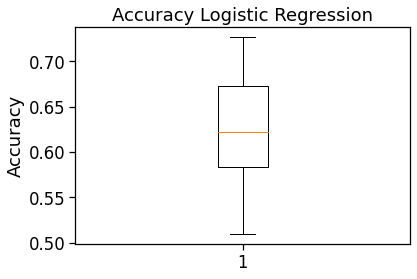

In [ ]:
# Virgin Logistic Regression
palette = sns.color_palette("Pastel2")
acc = cross_val_score(LogisticRegression(solver='lbfgs'), X, y, cv=10)
print(acc)
print(acc.mean())
plt.boxplot(acc)
plt.ylabel('Accuracy')
plt.title('Accuracy Logistic Regression')
plt.show()



In [ ]:
# Chad MLP
acc_1 = cross_val_score(MLPClassifier(random_state=1, max_iter=3000), X, y, cv=10)
print(acc_1)
print(acc_1.mean())
plt.boxplot(acc_1)
plt.show()

In [ ]:
# Chad MLP
acc_1 = cross_val_score(MLPClassifier(random_state=1, max_iter=3000), X, y, cv=10)
print(acc_1)
print(acc_1.mean())
plt.boxplot(acc_1)
plt.show()

[0.85714286 0.82142857 0.78571429 0.8        0.74545455 0.78181818
 0.85454545 0.87272727 0.83636364 0.76363636]
0.8118831168831168


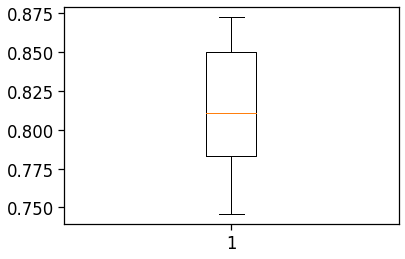

In [ ]:
# Chad MLP
acc = cross_val_score(MLPClassifier(random_state=1, max_iter=3000), X, y, cv=10)
print(acc)
print(acc.mean())
plt.boxplot(acc)
plt.show()

[0.5        0.46428571 0.41071429 0.52727273 0.50909091 0.4
 0.41818182 0.56363636 0.47272727 0.43636364]
0.4702272727272727


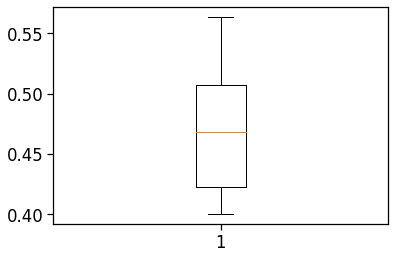

In [ ]:
# Falso
acc = cross_val_score(MLPClassifier(random_state=1, max_iter=3000), X, y_false, cv=10)
print(acc)
print(acc.mean())
plt.boxplot(acc)
plt.show()

In [ ]:
#@title Default title text
# K Neighbors
acc = cross_val_score(KNeighborsClassifier(n_neighbors=30), X, y, cv=10)
print(acc)
print(acc.mean())


[0.78571429 0.80357143 0.71428571 0.70909091 0.63636364 0.81818182
 0.83636364 0.81818182 0.76363636 0.69090909]
0.7576298701298703


In [ ]:
##ready for PCA
gab=np.array(vip_gab_gr)
score, evectors, evals = pca(gab[:,:-2].astype('float64'))
plot_eigenvalues(evals, limit=False)
plt.xlim(0,21)  # limit x-axis up to 100 for zooming
#X, labels = neX[:2000, :], labels_all[:2000]
X, labels = gab[:,:-1],[0 if s == 'familiar' else 1 for s in gab[:,-1]]
visualize_components(score[:, 0], score[:,1],labels)
 
# 0 = SST; 1=VIP
 

TypeError: ignored

In [ ]:
j=score[:,0:3]
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, perplexity=20, random_state=2020)
 
embed = tsne_model.fit_transform(gab[:,:-2])
print(embed.shape)
# Visualize the data
with plt.xkcd():
  visualize_components(embed[:, 0], embed[:, 1], labels)


In [ ]:
 
from numpy.ma.core import mean
 
#for i in range (len(gab.T)):
# 
yind=0
rows, cols = (1, 1)
neuron = []
#neuron=np.array(0,0)
fig, ax = plt.subplots(8,3,figsize=(10,15),sharey=True,sharex=False)
 
for y in range (len(gab.T)-1):
  neuronmean=[]
  neuronsem=[]
  for j in range (len(vip_gab_gr.exposure_level.unique())):
    neuron = []
    for i in range (len(gab)):
      if gab[i,-1]==j:
 
        neuron.append(gab[i,y])
 
        neuronmean.append(np.mean(neuron))
        neuronsem.append(np.std(neuron)/np.sqrt(np.count_nonzero(neuron)))
 #plt.subplot(8, 3, y+1)
 axx = y % 3
 axy = y // 3
 #print(axx,axy)
 thisax = ax[axy,axx]
 thisax.errorbar(list(range(0, 2)),neuronmean, neuronsem)
 ax[axy,0].set_ylabel('dF/F')
 ax[-1,axx].set_xlabel('Image')
 thisax.set_title(f'Neuron {y}')
 
 
fig.tight_layout()
